In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

In [5]:
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>
t_u.shape

torch.Size([11, 1])

In [6]:
t_u

tensor([[35.7000],
        [55.9000],
        [58.2000],
        [81.9000],
        [56.3000],
        [48.9000],
        [33.9000],
        [21.8000],
        [48.4000],
        [60.4000],
        [68.4000]])

In [7]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  5,  3,  0,  9, 10,  2,  7,  8]), tensor([4, 6]))

In [8]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [9]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-2.8945],
        [-1.8674]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model.weight

Parameter containing:
tensor([[-0.4585]], requires_grad=True)

In [11]:
linear_model.bias

Parameter containing:
tensor([-0.3130], requires_grad=True)

In [12]:
x = torch.ones(1)
linear_model(x)

tensor([-0.7715], grad_fn=<ViewBackward0>)

In [13]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715],
        [-0.7715]], grad_fn=<AddmmBackward0>)

In [14]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [15]:
linear_model.parameters()

<generator object Module.parameters at 0x13f86cdd0>

In [16]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7710]], requires_grad=True),
 Parameter containing:
 tensor([-0.9983], requires_grad=True)]

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [18]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 263.9325, Validation loss 92.5168
Epoch 1000, Training loss 3.5003, Validation loss 2.7769
Epoch 2000, Training loss 2.6083, Validation loss 4.4777
Epoch 3000, Training loss 2.5795, Validation loss 4.9151

Parameter containing:
tensor([[5.5384]], requires_grad=True)
Parameter containing:
tensor([-18.2270], requires_grad=True)


In [19]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 230.6422, Validation loss 69.7578
Epoch 1000, Training loss 3.6842, Validation loss 2.6596
Epoch 2000, Training loss 2.6143, Validation loss 4.4295
Epoch 3000, Training loss 2.5797, Validation loss 4.9056

Parameter containing:
tensor([[5.5367]], requires_grad=True)
Parameter containing:
tensor([-18.2171], requires_grad=True)


In [20]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [21]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [22]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [23]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [24]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [25]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1010], requires_grad=True)

In [26]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 214.3787, Validation loss 66.1656
Epoch 1000, Training loss 10.5233, Validation loss 11.3267
Epoch 2000, Training loss 3.7994, Validation loss 7.9019
Epoch 3000, Training loss 2.0618, Validation loss 6.6564
Epoch 4000, Training loss 1.4983, Validation loss 6.4859
Epoch 5000, Training loss 1.3884, Validation loss 6.5445
output tensor([[12.7032],
        [-0.2573]], grad_fn=<AddmmBackward0>)
answer tensor([[11.],
        [ 3.]])
hidden tensor([[ 1.2696e-03],
        [ 2.7579e+00],
        [-4.2954e+00],
        [-4.4862e+00],
        [ 3.0578e-02],
        [-4.3151e+00],
        [-3.5841e-02],
        [-2.1747e+00]])


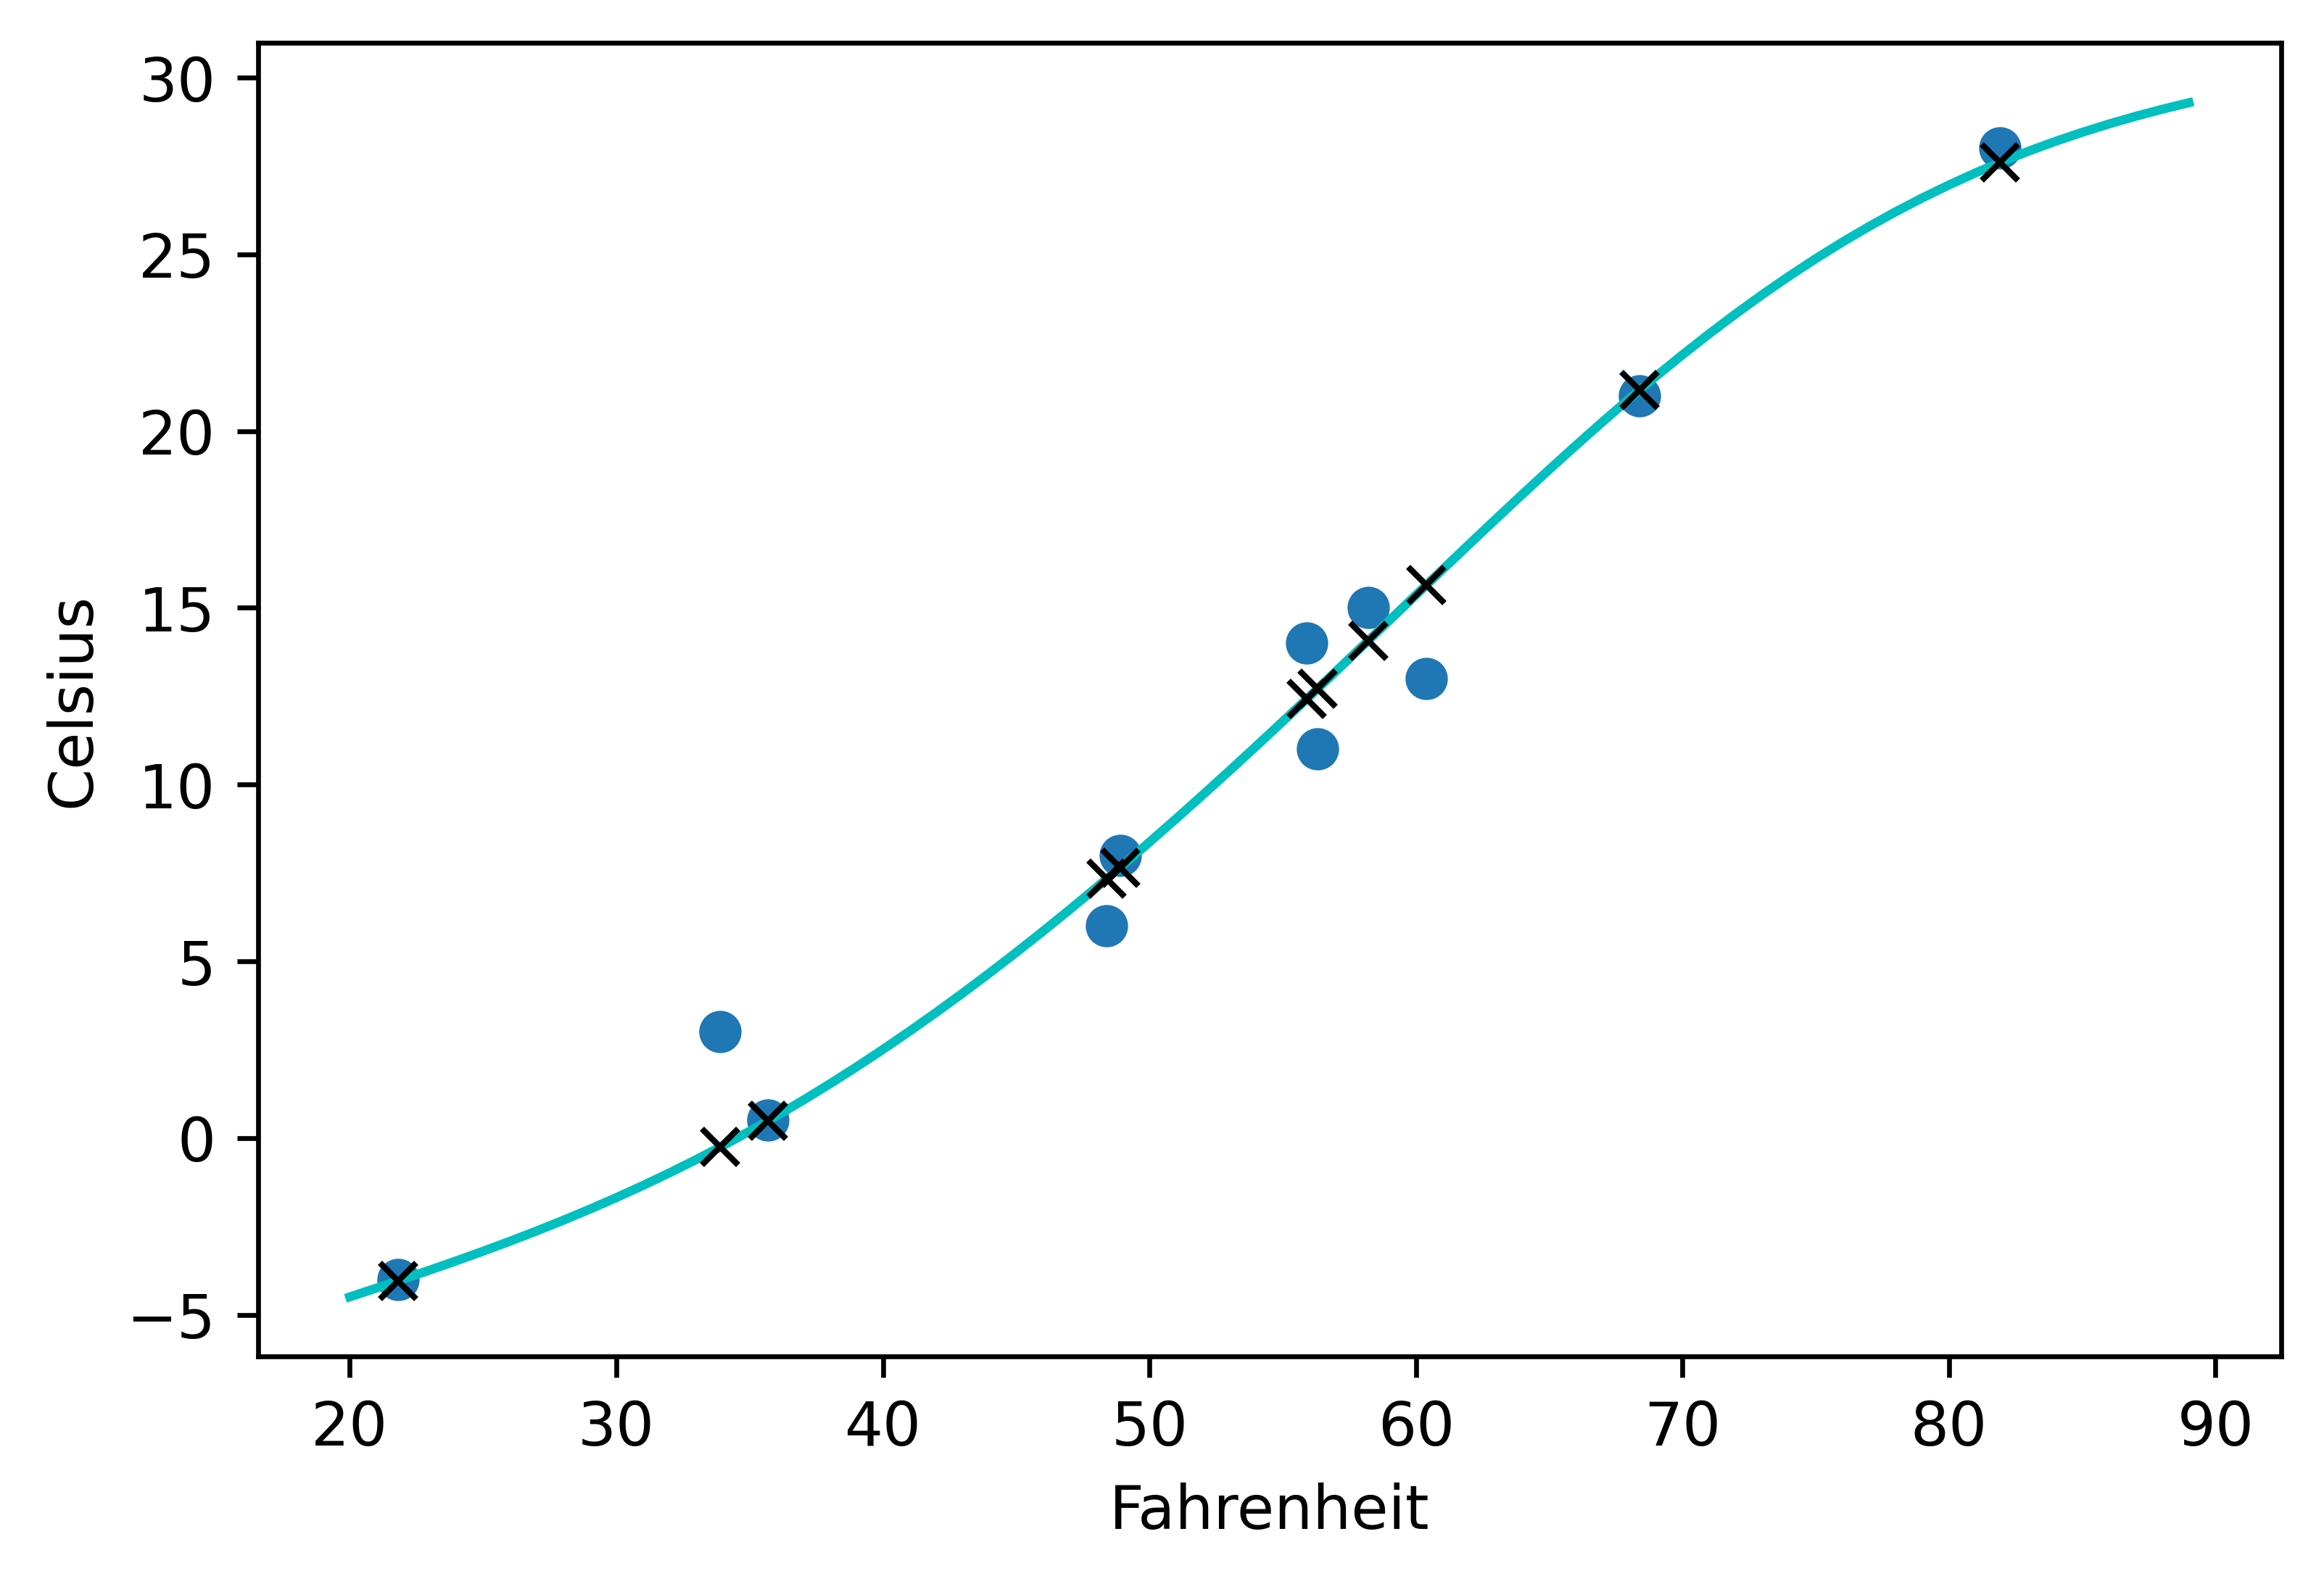

In [27]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 239.3185, Validation loss 80.4137
Epoch 1000, Training loss 59.1175, Validation loss 16.5412
Epoch 2000, Training loss 37.3363, Validation loss 8.7919
Epoch 3000, Training loss 20.9047, Validation loss 3.1193
Epoch 4000, Training loss 11.6102, Validation loss 2.2052
Epoch 5000, Training loss 7.0425, Validation loss 3.6139


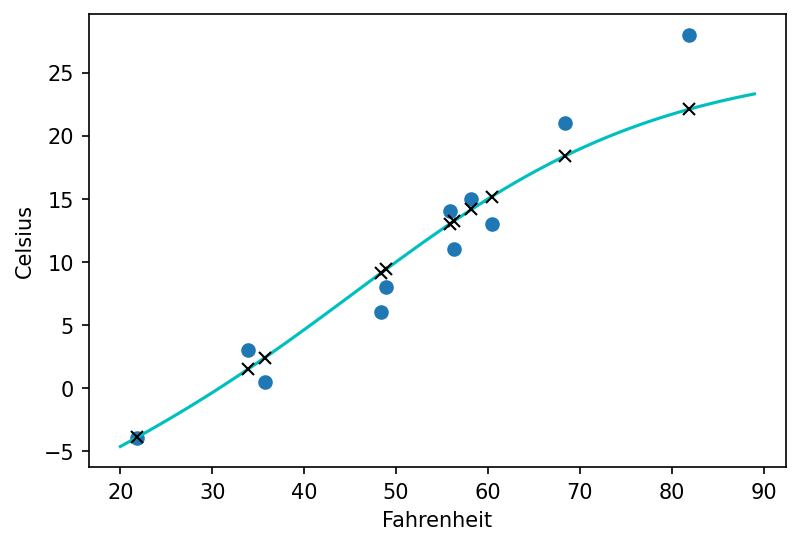

In [28]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
